# Image Classification
In this project, I'll classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. I'll preprocess the images, then train a convolutional neural network on all the samples. The images will be normalized and the labels will be one-hot encoded. At the end, I'll see the neural network's predictions on the sample images.
## Getting the Data
Running the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'
tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()

# Some test data to use while checking functions
tests.test_folder_path(cifar10_dataset_folder_path)

All files found!


## Exploring the Data
The dataset is broken into batches to prevent any memory problems. The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

When taking a look at the images in the batches below, I can see that they're randomly assigned and labeled 0 - 9(with their respective image) with a min value of 0 and a max value of 255(which makes sense since these are images with RGB values 0-255). The shappe of the image is just refering to the images width, hieght, and channel(3 channels for RGB).


Stats of batch 3:
Samples: 10000
Label Counts: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
First 20 Labels: [8, 5, 0, 6, 9, 2, 8, 3, 6, 2, 7, 4, 6, 9, 0, 0, 7, 3, 7, 2]

Example of Image 7:
Image - Min Value: 12 Max Value: 254
Image - Shape: (32, 32, 3)
Label - Label Id: 3 Name: cat


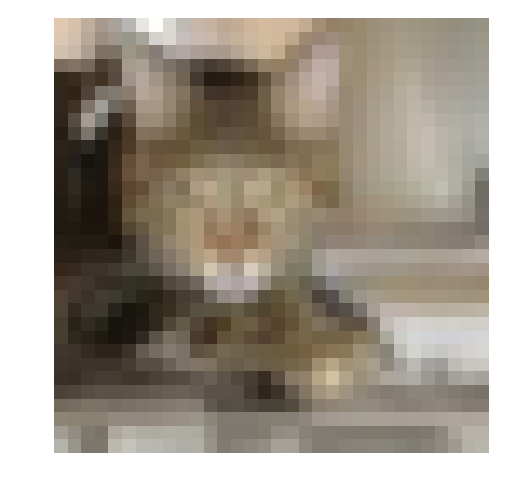

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

batch_id = 3
sample_id = 7
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Preprocessing the Data
### Normalize
In the cell below, I'll implement a `normalize` function to take in image data, `x`, and return it as a normalized Numpy array. The values will be in the range of 0 to 1, inclusive.  The return object will be the same shape as `x`.

In [16]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    # A simple normalize function
    return ((x - np.min(x))/(np.max(x) - np.min(x)))


tests.test_normalize(normalize)

Tests Passed


### One-hot encode
I'll implement the `one_hot_encode` function. The input, `x`, are a list of labels. The function will return the list of labels as One-Hot encoded Numpy array.  The possible values for labels are 0 to 9. 

In [17]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    # One-hot encode function
    """one_hot = np.zeros(shape=(len(x), 10))
    for i in range(len(x)):
        for j in range(10):
            one_hot[i][j] = (j == x[i])
    return one_hot"""
    # A simpler method to one-hot encode
    from sklearn import preprocessing
    lb=preprocessing.LabelBinarizer()
    lb.fit(range(10))
    return lb.transform(x)


tests.test_one_hot_encode(one_hot_encode)

Tests Passed


## Preprocess all the data and save it
The code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [18]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

In [19]:
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Building the network
For the neural network, I'll build each layer into a function.  Most of the code so far has been outside of functions. To test the code more thoroughly, I'll put each layer in a function.  This makes it easier to test for simple mistakes using some unittests before you project is completed.

### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability. The following functions will be implemented:

* `neural_net_image_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `image_shape` with batch size set to `None`.
 * Name the TensorFlow placeholder "x" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
 
* `neural_net_label_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `n_classes` with batch size set to `None`.
 * Name the TensorFlow placeholder "y" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
 
* `neural_net_keep_prob_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) for dropout keep probability.
 * Name the TensorFlow placeholder "keep_prob" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).

Note: `None` for shapes in TensorFlow allow for a dynamic size.

In [20]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    return tf.placeholder(tf.float32,shape=[None,*image_shape],name="x") 


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    return tf.placeholder(tf.float32,shape=[None,n_classes],name="y")


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    return tf.placeholder(tf.float32,name="keep_prob")


tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. For this code cell, I'll implement the function `conv2d_maxpool` to apply convolution then max pooling:
* Create the weight and bias using `conv_ksize`, `conv_num_outputs` and the shape of `x_tensor`.
* Apply a convolution to `x_tensor` using weight and `conv_strides`.
* Add bias.
* Add a nonlinear activation to the convolution.
* Apply Max Pooling using `pool_ksize` and `pool_strides`.

In [22]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    weights = tf.Variable(tf.truncated_normal([*conv_ksize, int(x_tensor.shape[3]), conv_num_outputs], mean=0.0, stddev=0.1, dtype=tf.float32))
    
    bias = tf.Variable(tf.zeros([conv_num_outputs]))

    conv_layer = tf.nn.conv2d(x_tensor, weights, strides=[1, conv_strides[0], conv_strides[1], 1], padding='SAME')

    conv_layer = tf.nn.bias_add(conv_layer, bias)

    conv_layer = tf.nn.relu(conv_layer)

    conv_layer = tf.nn.max_pool(conv_layer, ksize=[1, *pool_ksize, 1], strides=[1, *pool_strides, 1], padding='SAME')

    return conv_layer


tests.test_con_pool(conv2d_maxpool)

Tests Passed


### Flattening the Layer
I'll implement the `flatten` function to change the dimension of `x_tensor` from a 4-D tensor to a 2-D tensor.  The output should be the shape (*Batch Size*, *Flattened Image Size*). 

In [24]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    """
    # Starting at [1] since x_tensor is 4D and the batch_size is at [0] and should be left in tact(use -1 in reshape)
    width = int(x_tensor.shape[1])
    height = int(x_tensor.shape[2])
    depth = int(x_tensor.shape[3])

    flat2D = tf.reshape(x_tensor, [-1, height * width * depth])
    """
    #Updated version of above code
    new = np.prod([val for val in x_tensor.get_shape()[1:]])

    return tf.reshape(x_tensor, [-1, new.value])


tests.test_flatten(flatten)

Tests Passed


### Fully-Connected Layer
I'll implement the `fully_conn` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*).

In [25]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    weight = tf.Variable(tf.truncated_normal([int(x_tensor.shape[-1]), num_outputs], mean=0.0, stddev=0.1))

    bias = tf.Variable(tf.zeros([num_outputs]))

    full_conn = tf.add(tf.matmul(x_tensor, weight), bias)

    full_conn = tf.nn.relu(full_conn)

    return full_conn


tests.test_fully_conn(fully_conn)

Tests Passed


### Output Layer
I'll implement the `output` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*).

In [26]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    weight = tf.Variable(tf.truncated_normal([int(x_tensor.shape[-1]), num_outputs], mean=0.0, stddev=0.1))

    bias = tf.Variable(tf.zeros([num_outputs]))

    out = tf.add(tf.matmul(x_tensor, weight), bias)
    
    return out


tests.test_output(output)

Tests Passed


### Creating a Convolutional Model
I'll implement the function `conv_net` to create a convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits.  I'll use the layers I created above to create this model:

* Apply 1, 2, or 3 Convolution and Max Pool layers
* Apply a Flatten Layer
* Apply 1, 2, or 3 Fully Connected Layers
* Apply an Output Layer
* Return the output
* Apply [TensorFlow's Dropout](https://www.tensorflow.org/api_docs/python/tf/nn/dropout) to one or more layers in the model using `keep_prob`. 

In [27]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # Apply 1, 2, or 3 Convolution and Max Pool layers
    # Play around with different number of outputs, kernel size and stride
    # Function Definition from Above:
    #    conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    conv_size = (3,3)

    conv_strides = (1,1)

    pool_size = (2,2)

    pool_strides = (2,2)

    conv1 = conv2d_maxpool(x, 16, conv_size, conv_strides, pool_size, pool_strides)

    conv2 = conv2d_maxpool(conv1, 32, conv_size, conv_strides, pool_size, pool_strides)

    # Apply a Flatten Layer
    # Function Definition from Above:
    #   flatten(x_tensor)
    flat = flatten(conv2)

    # Apply 1, 2, or 3 Fully Connected Layers
    # Play around with different number of outputs
    # Function Definition from Above:
    #   fully_conn(x_tensor, num_outputs)
    full_conn1 = fully_conn(flat, 512)

    full_conn = tf.nn.dropout(full_conn1, keep_prob)
    
    # Apply an Output Layer
    # Set this to the number of classes
    # Function Definition from Above:
    #   output(x_tensor, num_outputs)
    out = output(full_conn, 10)
    
    # Return output
    return out


##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Neural Network Built!


## Training the Neural Network
### Single Optimization
I'll implement the function `train_neural_network` to do a single optimization.  The optimization will use `optimizer` to optimize in `session` with a `feed_dict` of the following:
* `x` for image input
* `y` for labels
* `keep_prob` for keep probability for dropout

This function will be called for each batch, so `tf.global_variables_initializer()` has already been called.

Note: Nothing needs to be returned. This function is only optimizing the neural network.

In [28]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    session.run(optimizer, feed_dict={x:feature_batch, y:label_batch, keep_prob:keep_probability})


tests.test_train_nn(train_neural_network)

Tests Passed


### Showing the Stats
I'll implement the function `print_stats` to print loss and validation accuracy. I'll use the global variables `valid_features` and `valid_labels` to calculate validation accuracy and a keep probability of `1.0` to calculate the loss and validation accuracy.

In [29]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    loss = session.run(cost, feed_dict={x:feature_batch, y:label_batch, keep_prob:1.0})

    val_acc = session.run(accuracy, feed_dict={x:valid_features, y:valid_labels, keep_prob:1.0})

    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, val_acc))

### Hyperparameters
Tune the following parameters:
* Set `epochs` to the number of iterations until the network stops learning or start overfitting
* Set `batch_size` to the highest number that your machine has memory for.
 * 64
 * 128
 * 256
 * ...
* Set `keep_probability` to the probability of keeping a node using dropout

In [35]:
# Having 10 epochs and a batch size of 128 seem to work best on my machine, I've also kept the probability to 1.0
epochs = 10
batch_size = 128
keep_probability = 1.0

**About the parameters:**

I tried 50 epochs but I was training for more than 2 hours and had just hit the 50% mark for completion with a batch size of 1024 and keep prob of 1.0. My accuracy was around 45%.

I then tried 25 epochs with a 512 batch size and keep prob of 1.0 and trained for an hour before stopping around the 18th epoch and had an accuracy of about 52%.

I then tried 10 epochs and a batch size of 128 with keep prob of 1.0 and achieved an accuracy of about 57%, this took around 30 mins for a full run.

I then tried 10 epochs with a batch size of 64 with a keep prob of 1.0 and reached an apex of 58% in the accuracy at epoch 7, which then declines to 54% for the remaining epochs.

**Note:** I could have trained again with smaller or bigger batch sizes(adjusting the epochs for each): 4096, 2048,..., 32, 16, 8, etc. But I felt 64 was a good size for the amount of time it took on my machine(approx 8 mins for 10 epochs). Also, smaller batch sizes tend to work better with smaller epochs, which is why I was reducing my epochs when reducing my batch sizes.

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, I'll use a single batch. This should save time while I iterate on the model to get a better accuracy.  Once the final validation accuracy is 50% or greater, run the model on all the data in the next section.

In [ ]:
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Loss:     1.7890 Validation Accuracy: 0.423600
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.4629 Validation Accuracy: 0.482000
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.2555 Validation Accuracy: 0.507800
Epoch  4, CIFAR-10 Batch 1:  Loss:     1.0914 Validation Accuracy: 0.522200


### Fully Training the Model
Now that I have decent accuracy with a single CIFAR-10 batch, I'll try it with all five batches.

In [67]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     1.7706 Validation Accuracy: 0.425600
Epoch  1, CIFAR-10 Batch 2:  Loss:     1.2356 Validation Accuracy: 0.486800
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.2110 Validation Accuracy: 0.515600
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.0826 Validation Accuracy: 0.559400
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.1616 Validation Accuracy: 0.583600
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.2566 Validation Accuracy: 0.591200
Epoch  2, CIFAR-10 Batch 2:  Loss:     0.8736 Validation Accuracy: 0.569600
Epoch  2, CIFAR-10 Batch 3:  Loss:     0.8018 Validation Accuracy: 0.600600
Epoch  2, CIFAR-10 Batch 4:  Loss:     0.7992 Validation Accuracy: 0.612600
Epoch  2, CIFAR-10 Batch 5:  Loss:     0.8404 Validation Accuracy: 0.627600
Epoch  3, CIFAR-10 Batch 1:  Loss:     0.9936 Validation Accuracy: 0.630600
Epoch  3, CIFAR-10 Batch 2:  Loss:     0.7198 Validation Accuracy: 0.629800
Epoch  3, CIFAR-10 Batch 3:  Loss:     0.6079 Validation Accuracy: 0.636800


## Testing Time
Now I'll test my model against the test dataset.  This will give the final accuracy. I should get an accuracy greater than 50%.

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.6480419303797469



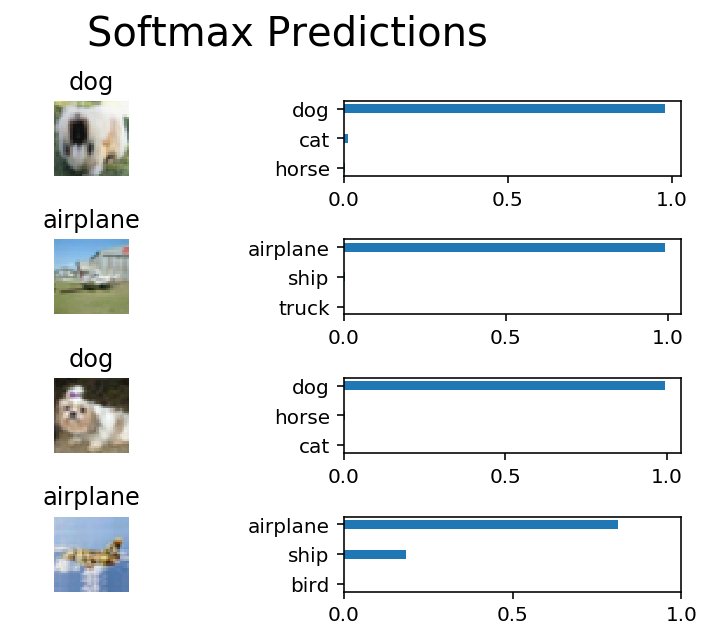

In [68]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

## Why 50-80% Accuracy?
First things first, 50% isn't bad for a simple CNN.  Pure guessing would get you 10% accuracy. However, you might notice people are getting scores [well above 80 (http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130).  That's because I still have more to learn about neural networks. After learning a few more tecniques, I should be able to revisit this project and achieve greater than 80% accuracy.